In [1]:
import rawpy
import imageio
import numpy as np
import cv2
import os

INPUT_FILE = "input/DSC_6514.dng"
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
import rawpy
import numpy as np
from PIL import Image




def preview_and_compare_img(original_img: np.ndarray, applied_styled_img: np.ndarray = None, width: int = 600) -> Image.Image:
    """
    Preview a np.ndarray DNG file, optionally comparing it side-by-side with a styled image.

    Parameters:
        original_img (np.ndarray, optionalr): .
        applied_styled_img (np.ndarray, optional): Styled RGB image to compare. If None, only original_img is shown.
        width (int): Resize width for display (height scaled proportionally).

    Returns:
        PIL.Image.Image: Single image (if no comparison) or side-by-side comparison.
    """
    def process_dng(path):
        with rawpy.imread(path) as raw:
            rgb = raw.postprocess(output_bps=8,                                                                     
                                  use_camera_wb=False,                                
                                #   no_auto_bright=True,                                
                                #   gamma=(1, 1)  # Linear gamma = raw-like rendering            
                                  )
        return rgb

    def resize_np_image(img_np, target_width):
        h, w = img_np.shape[:2]
        scale = target_width / w
        new_size = (target_width, int(h * scale))
        return Image.fromarray(img_np).resize(new_size)

    # Process original_img and resize
    img1_np = original_img
    img1_resized = resize_np_image(img1_np, width)

    # If styled image is not provided, return just the original
    if applied_styled_img is None:
        return img1_resized

    # Resize styled image
    styled_resized = resize_np_image(applied_styled_img, width)

    # Create combined preview
    combined = Image.new("RGB", (img1_resized.width + styled_resized.width, max(img1_resized.height, styled_resized.height)))
    combined.paste(img1_resized, (0, 0))
    combined.paste(styled_resized, (img1_resized.width, 0))

    return combined


In [3]:
def process_dng(path) -> np.ndarray:
        with rawpy.imread(path) as raw:
            rgb = raw.postprocess(output_bps=8,                                                                     
                                  use_camera_wb=False,                                
                                  use_auto_wb=False,
                                #   no_auto_bright=True,                                
                                #   gamma=(1, 1)  # Linear gamma = raw-like rendering            
                                  )
        return rgb

In [4]:
with rawpy.imread(INPUT_FILE) as raw_file:    
    print(dir(raw_file))


['__class__', '__delattr__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'black_level_per_channel', 'camera_white_level_per_channel', 'camera_whitebalance', 'close', 'color_desc', 'color_matrix', 'daylight_whitebalance', 'dcraw_make_mem_image', 'dcraw_make_mem_thumb', 'dcraw_process', 'extract_thumb', 'num_colors', 'open_buffer', 'open_file', 'postprocess', 'raw_color', 'raw_colors', 'raw_colors_visible', 'raw_image', 'raw_image_visible', 'raw_pattern', 'raw_type', 'raw_value', 'raw_value_visible', 'rgb_xyz_matrix', 'sizes', 'tone_curve', 'unpack', 'unpack_thumb', 'white_level']


In [5]:
raw_file.tone_curve

LibRawOutOfOrderCallError: b'Out of order call of libraw function'

raw.camera_whitebalance= [1.8066390752792358, 1.0, 1.2441401481628418, 0.0]


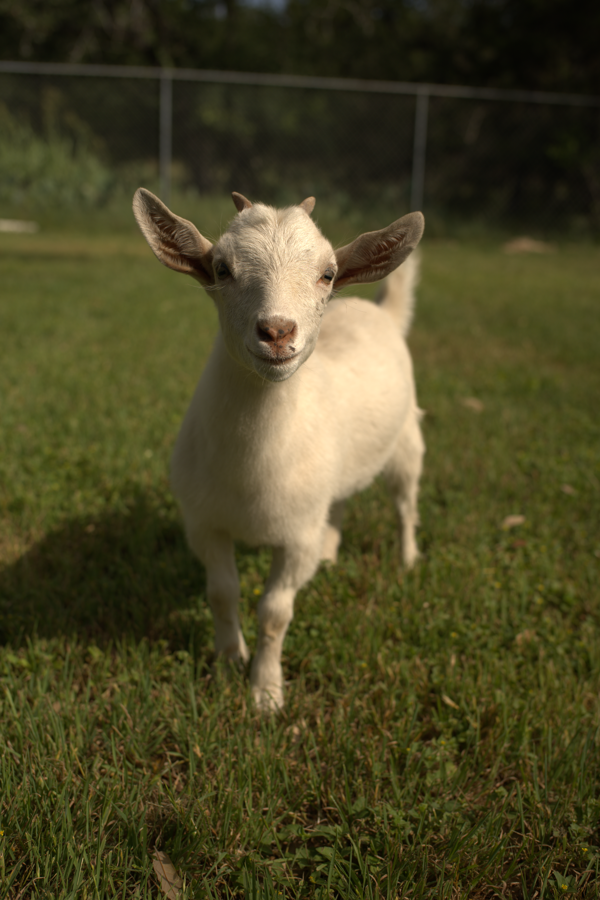

In [ ]:
# Without comparison
rgb = process_dng(INPUT_FILE)
img = preview_and_compare_img(rgb)
img.show()



In [ ]:
import subprocess
import json

def get_xmp_metadata(dng_path):
    result = subprocess.run(
        ["exiftool", "-XMP:All", "-json", dng_path],
        stdout=subprocess.PIPE,
        text=True
    )
    metadata = json.loads(result.stdout)[0]
    return metadata

In [ ]:
meta = get_xmp_metadata(INPUT_FILE)
for key, value in meta.items():
    print(f"{key}: {value}")

with open("meta.json", "w") as f:
    json.dump(meta, f, indent=4)

SourceFile: input/DSC_6514.dng
XMPToolkit: Adobe XMP Core 7.0-c000 1.000000, 0000/00/00-00:00:00        
CreatorTool: Adobe DNG Converter 17.3.1 (Windows)
CreateDate: 2025:05:22 09:55:02.15-05:00
ModifyDate: 2025:06:02 17:35:16-05:00
MetadataDate: 2025:06:02 17:35:16-05:00
Exposure2012: 0.0
LuminanceSmoothing: 46
LuminanceNoiseReductionDetail: 75
LuminanceNoiseReductionContrast: 0
ColorNoiseReduction: 25
ColorNoiseReductionDetail: 50
ColorNoiseReductionSmoothness: 50
Sharpness: 8
SharpenRadius: 2.0
SharpenDetail: 25
SharpenEdgeMasking: 0
Clarity2012: -6
Texture: 1
CameraProfile: Camera Flexible Color
Highlights2012: 0
Shadows2012: 0
Contrast2012: 0
Whites2012: 0
Blacks2012: 0
Saturation: 15
HueAdjustmentRed: 6
HueAdjustmentOrange: 14
HueAdjustmentYellow: -30
HueAdjustmentGreen: 42
HueAdjustmentAqua: 10
HueAdjustmentBlue: -10
HueAdjustmentPurple: 21
HueAdjustmentMagenta: -16
SaturationAdjustmentRed: 15
SaturationAdjustmentOrange: 10
SaturationAdjustmentYellow: -18
SaturationAdjustmentGr

In [ ]:
import numpy as np

def apply_tone_curve_to_image(rgb_image: np.ndarray, input_points: list, output_points: list) -> np.ndarray:
    """
    Apply a tone curve to an RGB image.

    Parameters:
        rgb_image (np.ndarray): RGB image as a NumPy array (H x W x 3), dtype=uint8.
        input_points (list): Tone curve input values (e.g., [0, 32, 64, 128, 192, 255]).
        output_points (list): Corresponding output values (same length as input_points).

    Returns:
        np.ndarray: Tone-curve-adjusted RGB image (uint8).
    """
    # Build tone curve
    tone_curve = np.interp(np.arange(256), input_points, output_points).astype(np.uint8)

    # Apply tone curve to each RGB channel
    adjusted = np.empty_like(rgb_image)
    for c in range(3):
        adjusted[..., c] = tone_curve[rgb_image[..., c]]

    return adjusted


In [ ]:
import imageio

# Define the tone curve using the extracted control points  (Fuji Superia)
input_points = np.array([6, 39, 75, 138, 175, 219, 253])
output_points = np.array([0, 11, 38, 140, 185, 221, 245])
tone_curve = np.interp(np.arange(256), input_points, output_points).astype(np.uint8)

# imageio.imwrite("output.jpg", apply_tone_curve_to_dng(INPUT_FILE, input_points, output_points))


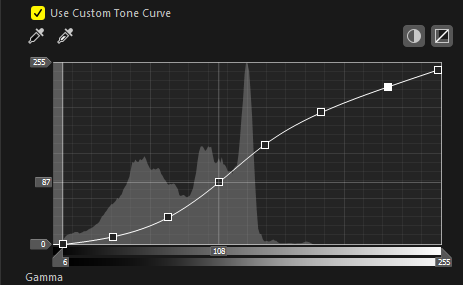
```
# Define the tone curve using the extracted control points
input_points = np.array([6, 39, 75, 138, 175, 219, 253])
output_points = np.array([0, 11, 38, 140, 185, 221, 245])
tone_curve = np.interp(np.arange(256), input_points, output_points).astype(np.uint8)
```

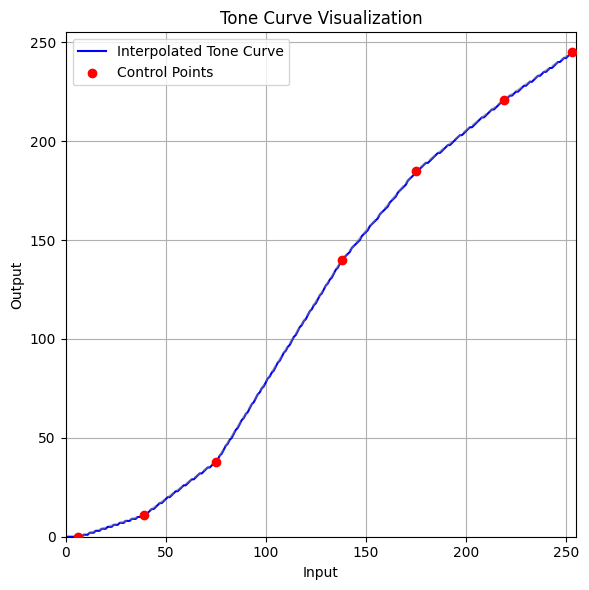

In [ ]:
import matplotlib.pyplot as plt

def visualize_tone_curve(input_points: np.ndarray, output_points: np.ndarray, tone_curve: np.ndarray):
    """
    Visualize the tone curve along with the original control points.

    Parameters:
        input_points (np.ndarray): Array of input values used for interpolation.
        output_points (np.ndarray): Array of output values corresponding to input_points.
        tone_curve (np.ndarray): Full interpolated tone curve (256 values).
    """
    x = np.arange(256)
    y = tone_curve

    plt.figure(figsize=(6, 6))
    plt.plot(x, y, label="Interpolated Tone Curve", color='blue')
    plt.scatter(input_points, output_points, color='red', label="Control Points", zorder=5)
    plt.plot(input_points, output_points, '--', color='gray', alpha=0.5)
    plt.title("Tone Curve Visualization")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.xlim(0, 255)
    plt.ylim(0, 255)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
tone_curve = np.interp(np.arange(256), input_points, output_points).astype(np.uint8)

visualize_tone_curve(input_points, output_points, tone_curve)

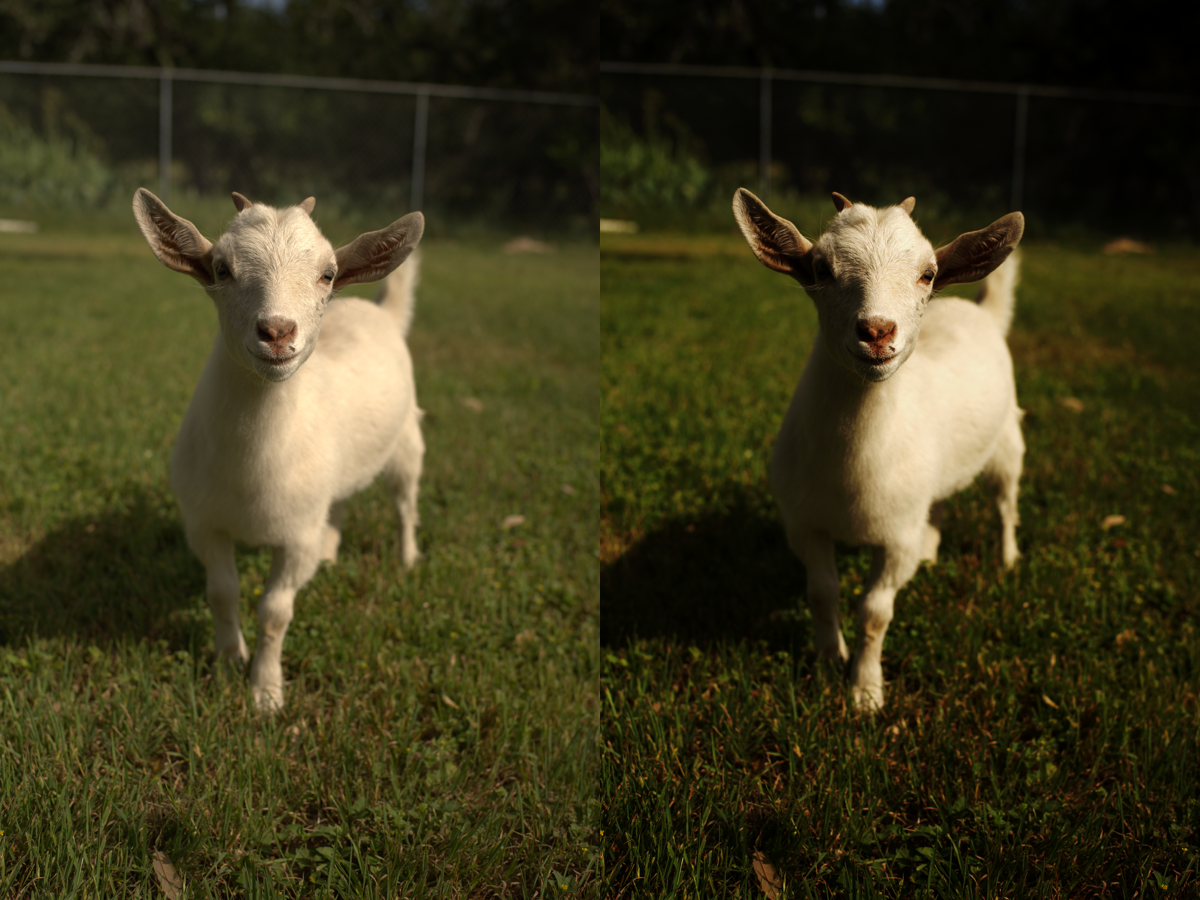

In [ ]:
img_applied_tone_curve = apply_tone_curve_to_image(rgb, input_points, output_points)

# With comparison
img = preview_and_compare_img(rgb, applied_styled_img=img_applied_tone_curve)
img.show()